In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import statistics
import nltk
import re
from scipy import stats
from venn import venn
import matplotlib
import squarify
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords  
from gensim.parsing.preprocessing import STOPWORDS
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize  
%matplotlib inline

In [4]:
recipes = pd.read_csv('data/large_data/recipes.csv')
ingredient_freq = pd.read_csv('data/recipes/ingredient_freq.csv')
interactions = pd.read_csv('data/large_data/RAW_interactions.csv')

In [5]:
def calc_ingredient_ratings(ingredient_list, ingredient_freq= ingredient_freq):
    #print(ingredient_list) 
    rating = 0
    for ingredient in ingredient_list:
        try:
            freq = ingredient_freq.loc[ingredient]
        except:
            freq = 0
        rating += freq
    return rating

In [6]:
def get_recipes(search_phrase, recipes):
    recipe_list = recipes.loc[recipes['name'].str.contains(search_phrase, case=False)].copy()
    recipe_list['ingredient_score'] = recipe_list['mod_ingredients'].apply(calc_ingredient_ratings)
    recipe_list['overall_score'] = stats.zscore(recipe_list['minutes']) + recipe_list['avg_rating']*recipe_list['n_ratings'] + recipe_list['ingredient_score']*100 + stats.zscore(recipe_list['n_steps']) + stats.zscore(recipe_list['n_ingredients'])
    return recipe_list

In [7]:
def show_top_recipes(recipe_list):
    html = 'https://www.food.com/recipe/'
    common_ingredients = recipe_list['mod_ingredients'].apply(literal_eval).explode().value_counts()
    cmap = matplotlib.cm.Blues
    norm = matplotlib.colors.Normalize(vmin=min(common_ingredients), vmax=max(common_ingredients))
    colors = [cmap(norm(value)) for value in common_ingredients]
    squarify.plot(sizes=common_ingredients[:10], label=common_ingredients.index[:10], alpha=.5, text_kwargs={"wrap": True})
    plt.axis('off')
    plt.show()
    top_5 = recipe_list.nlargest(5, 'overall_score').copy()
    top_5['recipe_link'] = [f'https://www.food.com/recipe/{ing_id}' for ing_id in top_5['id']]
    return top_5[['name','id','overall_score','recipe_link']]

In [8]:
text = interactions[interactions['recipe_id'].isin(recipe_list.id)]['review'].apply(str.split).explode()
text = interactions[interactions['recipe_id'].isin(recipe_list.id)]['review'].apply(word_tokenize).explode()
text = [word.lower().translate(str.maketrans('', '', str.punctuation)) for word in text]
print(len(text))
text = [w.lower() for w in text if not w.lower() in stop_words]
print(text[0:10])
text = [word for word in text if re.sub(r'[^\\w\\s]','', word) == word]

NameError: name 'recipe_list' is not defined

In [9]:
def make_wordcloud(recipe_list):
    stop_words = stopwords.words('english')
    stop_words.extend(['i','ive',"i've",'didnt','them', 'little','use','added','good','great', 'think', 'taste',\
                       'recipe', 'used','made','make','still','also','baked','bake','thank','thanks','cup'])
    #stop_words = set(stop_words)
    stop_words = STOPWORDS.union(set(stop_words))
    review_list = interactions[interactions['recipe_id'].isin(recipe_list.id)]['review']
    text = " ".join(review for review in review_list)
    wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [10]:
def main():
    search_phrase = input('Please enter your recipe: ')
    #search_words = search_phrase.split(" ")
    #search_words = "|".join("^{}$".format(word) for word in search_words)
    recipe_list = get_recipes(search_phrase, recipes)
    #print(recipe_list)
    #print(interactions[interactions['recipe_id'].isin(recipe_list.id)]['review'])
    make_wordcloud(recipe_list)
    return show_top_recipes(recipe_list)

Please enter your recipe: butternut squash soup


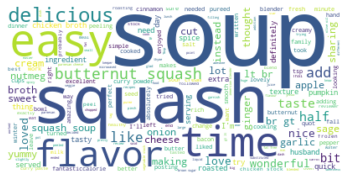

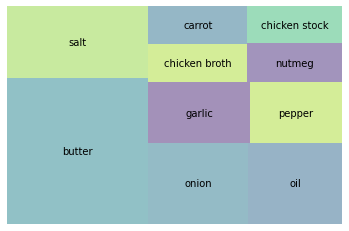

,name,id,overall_score,recipe_link
164955,quick butternut squash soup,17987,672.157168,https://www.food.com/recipe/17987
206313,thai style butternut squash soup,38904,131.427451,https://www.food.com/recipe/38904
135980,moosewood s butternut squash soup with sage,19650,66.834241,https://www.food.com/recipe/19650
76555,easy to make butternut squash soup,281532,51.688397,https://www.food.com/recipe/281532
31731,butternut squash soup or bisque roasting method,260929,38.888164,https://www.food.com/recipe/260929


In [130]:
main()